# Machine Learning Fundamentals

## Summary

- Problem formulation

## Problem formulation

### The elements of a supervised ML system

1. Some **data** under numeric form.
1. A **model** able to produce results from data.
1. A **loss (or cost) function** to quantify the model error (difference between expected and actual results).
1. An **optimization algorithm** to update the model's parameters in order to minimize the loss.

### Terminology and notations

- **Feature**: property of a data sample, named $ x^{(i)}_j $.
- **Sample**: a particular instance of data, vector of $ n $ features, named $ \mathbf{x}^{(i)} = \left\{ x^{(i)}_1, x^{(i)}_2, \dotsc, x^{(i)}_n \right\} $.
- **Label** (or *target*): expected result for a sample, vector of $ K $ values, named $ \mathbf{y}^{(i)} = \left\{ y^{(i)}_1, y^{(i)}_2, \dotsc, y^{(i)}_K \right\} $.
- The number of samples and associated results is named $ m $.

Most ML algorithms except input data to come as a 2-dimensional matrix (*samples, features*)

- First dimension is for the $ m $ samples.
- Second dimension is for the $ n $ features of each sample.

Targets should be formatted using the same first dimension.

$$\mathbf{X} = \begin{pmatrix}
       \ x^{(1)}_1 & x^{(1)}_2 & \cdots & x^{(1)}_n \\
       \ x^{(2)}_1 & x^{(2)}_2 & \cdots & x^{(2)}_n \\
       \ \vdots & \vdots & \ddots & \vdots \\
       \ x^{(m)}_1 & x^{(m)}_2 & \cdots & x^{(m)}_n
     \end{pmatrix}\;\;
\mathbf{Y} = \begin{pmatrix}
       \ y^{(1)}_1 & y^{(1)}_2 & \cdots & y^{(1)}_K \\
       \ y^{(2)}_1 & y^{(2)}_2 & \cdots & y^{(2)}_K \\
       \ \vdots & \vdots & \ddots & \vdots \\
       \ y^{(m)}_1 & y^{(m)}_2 & \cdots & y^{(m)}_K
     \end{pmatrix}$$

### Multidimensional data: reshaping

A bitmap image can be represented as a 3D multidimensional array (*height, width, color_channels*).

A video can be represented as a 4D multidimensional array (*frames, height, width, color_channels*).

They have to be **reshaped**, or *flattened* in that case, into a vector before being fed to most ML models.

![Image to vector](images/image2vector.jpeg)

### Example: the MNIST handwritten digits datasets

Dataset of 70,000 handwritten digits, stored as 28x28 grayscale images.

Staple of Machine Learning since 1998.

In [7]:
import platform
print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Python version: 3.7.5


In [34]:
import sklearn
print(f'scikit-learn version: {sklearn.__version__}')
assert sklearn.__version__ >= "0.20"

from sklearn.linear_model import SGDClassifier

import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
print(f'Keras version: {tf.keras.__version__}')

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

scikit-learn version: 0.22.1
TensorFlow version: 2.0.0
Keras version: 2.2.4-tf


In [31]:
# Load the MNIST digits dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(f"Training images: {train_images.shape}. Training labels: {train_labels.shape}")
print(f"Test images: {test_images.shape}. Test labels: {test_labels.shape}")

Training images: (60000, 28, 28). Training labels: (60000,)
Test images: (10000, 28, 28). Test labels: (10000,)


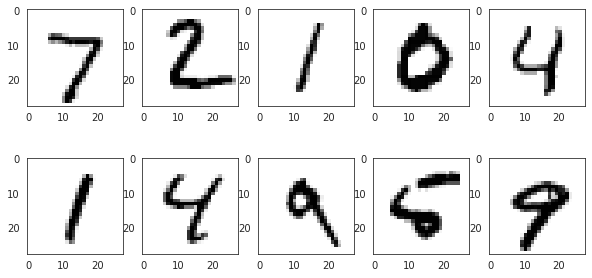

In [14]:
# Plot the first 10 digits
with sns.axes_style('white'):  # Temporary hide Seaborn grid lines
    plt.figure(figsize=(10, 5))
    for i in range(10):
        digit = test_images[i]
        fig = plt.subplot(2, 5, i + 1)
        plt.imshow(digit, cmap=plt.cm.binary)

In [35]:
# Reshape images into a (samples, 28x28) matrix
x_train = train_images.reshape((60000, 28 * 28))
x_test = test_images.reshape((10000, 28 * 28))

# 784=28x28
print(f"x_train: {x_train.shape}")

x_train: (60000, 784)


### Multidimensional data: scaling

Individual pixel values for images and videos are typically integers in the [0:255] range.

Scaling them to obtain floats into the [0:1] ensures is a common practice.

In [ ]:
# Rescale pixel values from [0:255] to [0:1]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

### The model

- Defines the relationship between features and labels.
- Contains a set of **parameters**, named the $ \theta $ vector (sometimes noted $ \omega $).
- Its prediction function is called the *hypothesis* and named $h_\theta()$. It outputs a prediction named $ \mathbf{y}'^{(i)} $ or $ \hat{\mathbf{y}}^{(i)} $.

$$ \mathbf{y}'^{(i)} = h_\theta(\mathbf{x}^{(i)}) = \left\{ y'^{(i)}_1, y'^{(i)}_2, \dotsc, y'^{(i)}_K \right\} $$ 

### The loss function

- Quantifies the difference between expected results (*ground truth*) and actual results calculated by the model.
- The loss function is named $ \mathcal{L}() $ or sometimes $ \mathcal{J}() $
- Different loss functions exists. The choice depends on the learning type.

### Loss functions for regression

- *Mean Absolute Error* (aka *l1 or Manhattan norm*):
$$ \mathrm{MAE}(\mathbf{X}, h_\theta) = \frac{1}{m}\sum_{i=1}^m |\mathbf{y}'^{(i)} - \mathbf{y}^{(i)}| $$
- *Mean Squared Error* (aka *l2 norm*):
$$ \mathrm{MSE}(\mathbf{X},h_\theta) = \frac{1}{m}\sum_{i=1}^m (\mathbf{y}'^{(i)} - \mathbf{y}^{(i)})^2 $$
- *Root Mean Squared Error* (aka *Euclidean norm*):
$$ \mathrm{RMSE}(\mathbf{X},h_\theta) = \sqrt{\frac{1}{m}\sum_{i=1}^m (\mathbf{y}'^{(i)} - \mathbf{y}^{(i)})^2} $$

### Targets

In [18]:
# Show 10 random labels (integer scalars between 0 and 9)
df_train_labels = pd.DataFrame(train_labels)
df_train_labels.columns = {'digit'}
df_train_labels.sample(n=10)

,digit
15665,4
14180,5
19861,0
9443,3
54236,1
6410,3
40498,2
8255,1
2254,4
21007,3


In [32]:
# One-hot encoding of expected results
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

print(f"y_train: {y_train.shape}")

# Show random samples of encoded input
df_y_train = pd.DataFrame(y_train)
df_y_train.sample(n=6)

y_train: (60000, 10)


,0,1,2,3,4,5,6,7,8,9
59858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26686,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
21142,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
